### Introduction to AutoEncoder(AE) in Pytorch
This is a minimalist and simple demo of AutoEncoder(AE) in Pytorch working with MNIST dataset.
There are 60000 images in training data and 10000 in testing.

### Import Libaries

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torchvision as tv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torchvision.transforms as transforms

### Define Global Variables

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Batch Size for Train&Test Process
BATCH_SIZE = 256
# Learning rate of Optimizer
LEARNING_RATE = 0.001
# Weight Decay for Optimizer
WEIGHT_DECAY = 1e-5
# Training Epochs
EPOCH = 100
# Length of Hidden Vector
HIDDEN_SIZE = 2

DEVICE

device(type='cuda', index=0)

### Download Mnist Dataset
Images in the MNIST Dataset are in grayscale, they are made of 28*28 pixels whose values range between 0 and 255.
Notice that since its grayscale, we only have one number per pixel.
In contrast, if the images where colored, then we would have 3 numbers per pixel, each one of them representing the intensity of Red, Green and Blue (RGB).
In Pytorch there’s a two-step process to use a dataset.
- Create a Dataset object. You can consider this as an abstract version of the dataset you want to work with. It has key informations such as its length and how to grab batches from it. By creating this Dataset object you download the data and prepare the groundwork for the Dataloader object.
- Create a Dataloader object. This is an object that you can iterate over and it will give you a batch of data and its corresponding labels.

Importantly, when defining the Dataset object, you can specify how to preprocess the data, e.g. scaling the data.
In AE we are assuming that each feature (i.e. each pixel value) can be interpreted as a probability. For this reason, we want to scale our pixel values to be in the range [0,1].

> Notice that very often, when using other methods, people normalize the pixel values to be centered around zero and to have unit standard deviation. This must not be done in this case because we cannot have negative pixel values.

There are 60000 Images In Train Dataset and 10000 Images In Test Dataset


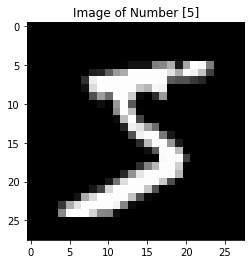

In [3]:
# Create Dataset object.s Notice that ToTensor() transforms images to pytorch
# tensors AND scales the pixel values to be within [0, 1]. Also, we have separate Dataset
# objects for training and test sets. Data will be downloaded to a folder called 'data'.
trainset = tv.datasets.MNIST(
    root='E:\\data\\mnist',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
testset = tv.datasets.MNIST(
    root='E:\\data\\mnist',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Create DataLoader objects. These will give us our batches of training and testing data.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

# Overview & Show Sample
print(
    "There are {0} Images In Train Dataset and {1} Images In Test Dataset".format(
        trainset.data.size()[0],
        testset.data.size()[0]
    )
)
plt.title("Image of Number [{}]".format(trainset.targets[0]))
plt.imshow(trainset.data[0].numpy(), cmap="gray")
plt.show()

### Define AutoEncoder
![AutoEncoder](https://keras-cn.readthedocs.io/en/latest/legacy/images/autoencoder_schema.jpg)
We create a model named *AutoEncoder* inheriting from Pytorch's *nn.Model* class.

In [4]:
class AutoEncoder(nn.Module):
	def __init__(self):
		super(AutoEncoder, self).__init__()
		self.encoder=nn.Sequential(
					nn.Linear(28*28, 128),
					nn.ReLU(),
                    nn.Dropout(0.01),
					nn.Linear(128, 64),
					nn.ReLU(),
                    nn.Dropout(0.01),
                    nn.Linear(64, 32),
					nn.ReLU(),
                    nn.Dropout(0.01),
					nn.Linear(32, HIDDEN_SIZE)
					)
		self.decoder = nn.Sequential(
					nn.Linear(HIDDEN_SIZE, 32),
					nn.ReLU(),
                    nn.Dropout(0.01),
                    nn.Linear(32, 64),
					nn.ReLU(),
                    nn.Dropout(0.01),
					nn.Linear(64, 128),
					nn.ReLU(),
                    nn.Dropout(0.01),
					nn.Linear(128, 28*28),
					nn.Sigmoid(), # 数值压缩到(0,1)
					)

	def forward(self, inputs):
		encoded_vector = self.encoder(inputs)
		decoded_vector = self.decoder(encoded_vector)
		return encoded_vector, decoded_vector

In [5]:
autoencoder = AutoEncoder().to(DEVICE)
optimizer=torch.optim.Adam(autoencoder.parameters(),lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_func=nn.MSELoss()
view_data=trainset.data[:10].view(-1, 28*28).type(torch.FloatTensor).to(DEVICE)

Epoch:  0 | train loss: 0.2314


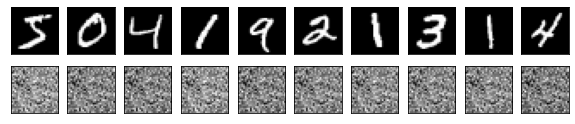

Epoch:  10 | train loss: 0.0431


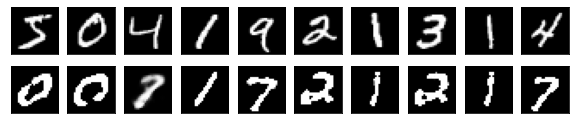

Epoch:  20 | train loss: 0.0389


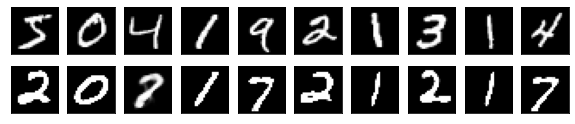

Epoch:  30 | train loss: 0.0380


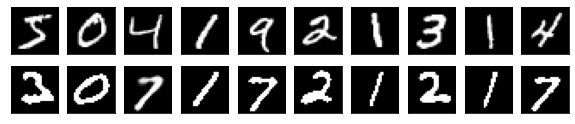

Epoch:  40 | train loss: 0.0401


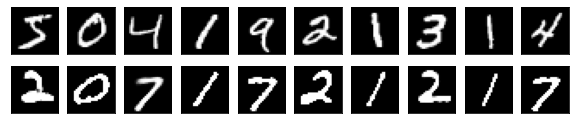

Epoch:  50 | train loss: 0.0378


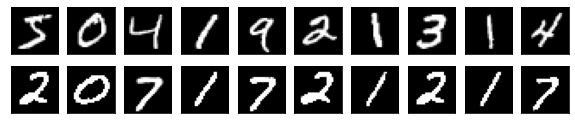

Epoch:  60 | train loss: 0.0369


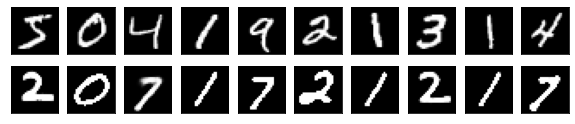

Epoch:  70 | train loss: 0.0382


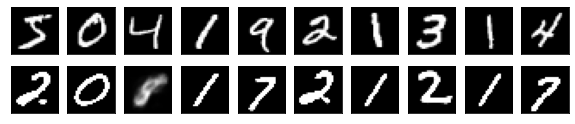

Epoch:  80 | train loss: 0.0385


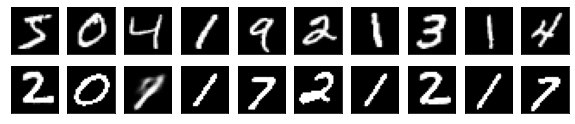

Epoch:  90 | train loss: 0.0357


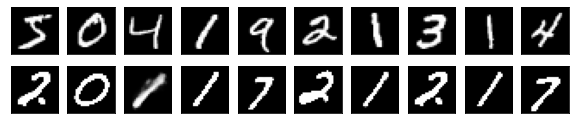

Epoch:  100 | train loss: 0.0389


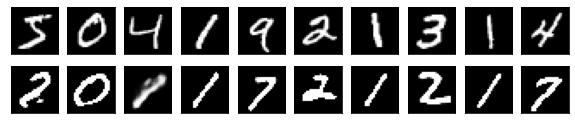

In [6]:
for epoch in range(EPOCH+1):
    for step, (x, y) in enumerate(trainloader):
        b_x = x.view(-1, 28 * 28).to(DEVICE)
        b_y = x.view(-1, 28 * 28).to(DEVICE)
        b_label = y.to(DEVICE)

        optimizer.zero_grad()

        encoded, decoded = autoencoder(b_x)
        loss = loss_func(decoded, b_y)  # MSE损失函数
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新梯度
        if step % 500 == 0 and epoch % 10 == 0:
            print("Epoch: ", epoch, "| train loss: %.4f" % loss.item())
            # 绘制解码器图像
            _, decoded_data = autoencoder(view_data)
            # 初始化画布
            f, a = plt.subplots(2, 10, figsize=(10, 2))
            for i in range(10):
                a[0][i].imshow(np.reshape(view_data.data.cpu().detach().numpy()[i], (28, 28)), cmap="gray")
                a[0][i].set_xticks(())
                a[0][i].set_yticks(())
            for i in range(10):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.cpu().detach().numpy()[i], (28, 28)), cmap="gray")
                a[1][i].set_xticks(())
                a[1][i].set_yticks(())
            plt.show()

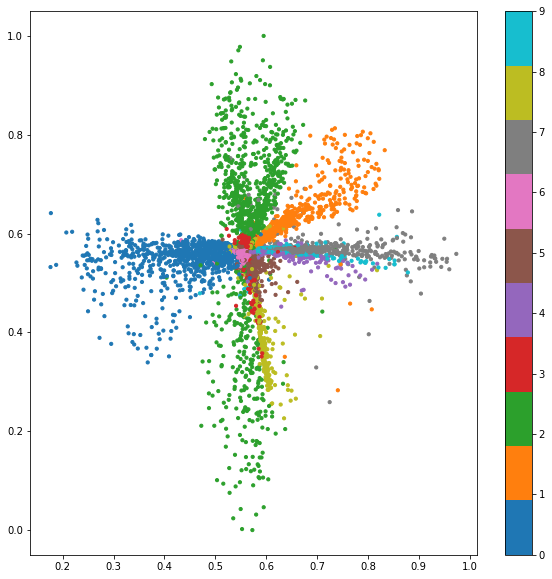

In [10]:
autoencoder.eval()
with torch.no_grad():
    image_test=testset.data.view(-1, 28*28).type(torch.FloatTensor).to(DEVICE)
    image_encoded = autoencoder.encoder(image_test)
    image_2d = image_encoded.cpu().detach().numpy()
    if HIDDEN_SIZE > 2:
        tsne = TSNE()
        image_2d = tsne.fit_transform(image_2d)
    image_2d = (image_2d-image_2d.min()) / (image_2d.max()-image_2d.min())

    plt.figure(figsize=(10, 10))
    # 如果想使用渐变色，设置 cmap='viridis'
    plt.scatter(image_2d[:, 0], image_2d[:, 1], c=testset.targets, s=10, cmap='tab10')
    plt.colorbar()
    plt.show()

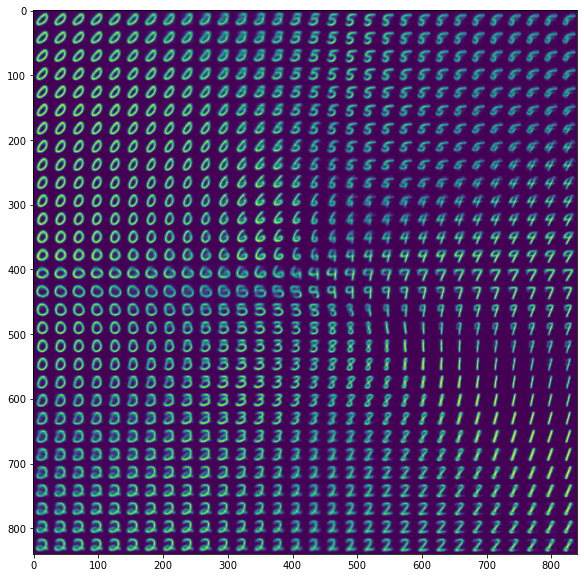

In [8]:
n = 30  # figure with 15x15 digits
digit_size = 28
if HIDDEN_SIZE == 2:
    autoencoder.eval()
    with torch.no_grad():
        # display a 2D manifold of the digits
        figure = np.zeros((digit_size * n, digit_size * n))
        # we will sample n points within [-15, 15] standard deviations
        grid_x = np.linspace(-15.0, 15.0, 30)
        grid_y = np.linspace(-15.0, 15.0, 30)
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = np.array([xi, yi])
                x_decoded = autoencoder.decoder(torch.from_numpy(z_sample).to(torch.float32).to(DEVICE))
                digit = x_decoded.reshape(digit_size, digit_size).cpu().detach().numpy()
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        plt.figure(figsize=(10, 10))
        plt.imshow(figure)
        plt.show()

### Reference
https://maurocamaraescudero.netlify.app/post/minimalist-variational-autoencoder-in-pytorch-with-cuda-gpu/